## Exam 3 Week 16    

### Timothy Schock

#### Value 2000 pts

In [57]:
# Import necessary packages
import pandas as pd
import numpy as np

# Utility packages
import os
import re
import pytz
import geopandas as gpd
import pyproj
import plotly
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic
import gpxpy

# Data management packages
from gpxcsv import gpxtolist
from timezonefinder import TimezoneFinder

# Machine Learning packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Other packages - preprocessing
import random
import math
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import num2words
from collections import Counter


### Question 1 (1000 pts)

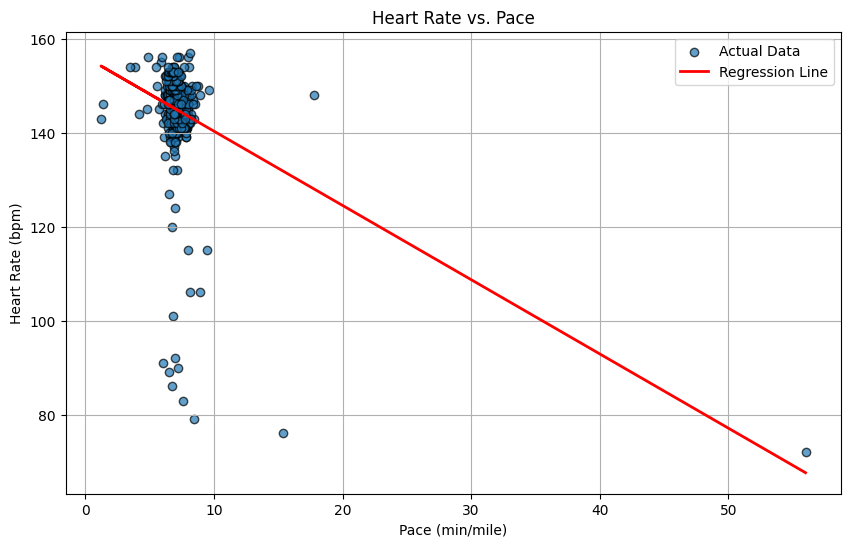

Skipping Track-13.gpx due to error: Invalid activity type 'cycling'. Must be one of ['running', 'walking', 'hiking'].
Skipping Track-14.gpx due to error: Invalid activity type 'cycling'. Must be one of ['running', 'walking', 'hiking'].
Skipping Track-4.gpx: 'type' column not found.


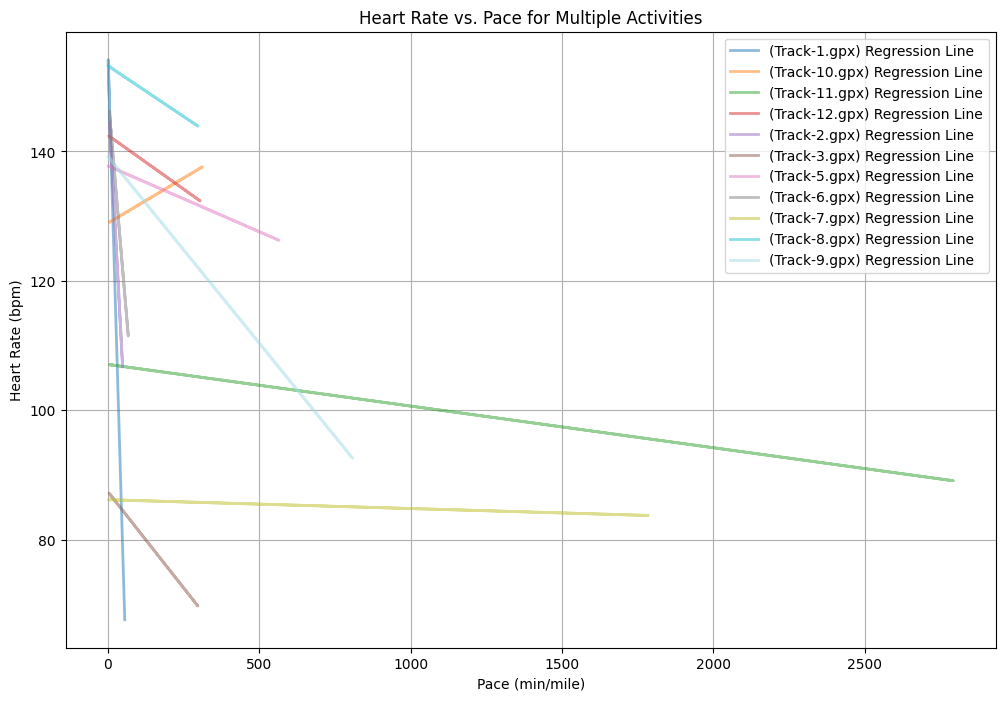

In [58]:
# Provide your answer in cells here and below.

# Taken from Term 1 summary to help compute pace
def compute_time_deltas(dt_array,output='seconds'):
    # Compute time deltas between records in a datetime array 
    # params:
    #
    #  array of datetime objects
    #  output type: 'seconds' or 'td' or 'timedelta
    
    delta = [0] * len(dt_array)
    delta_seconds = [0] * len(dt_array)
    
    for i in range(1,len(dt_array)):
        delta[i] = (dt_array[i] - dt_array[i-1])
        delta_seconds[i] = delta[i].total_seconds()
    
    if output=='seconds':
        return delta_seconds
    elif output == 'td' or output == 'timedelta':
        return delta
    else:
        print(f'unknown output format {output}')

# Taken from Term 1 summary to help compute pace
def compute_dist_deltas(point_array):
    # Compute the distance between successive points in a Point geometry array
    #
    # params:
    #   point_array - array of Point geometry objects
    
    dist = [point_array[i].distance(point_array[i-1]) for i in range(1, len(point_array))]
    dist.insert(0,0)

    return dist


def analyze_heart_rate_vs_pace(activity_df, smooth_pace=True, plot=True):
    # Analyzes heart rate as a function of pace for running, walking, or hiking activities.
    #
    # params:
    #   activity_df: DataFrame containing activity data from data frame
    #   smooth_pace: Whether to smooth the pace or not
    #   plot: Whether to display the plot or not

    # Ensure the activity type is provided in the 'type' column
    if 'type' not in activity_df.columns:
        raise ValueError("The DataFrame does not contain the 'type' column.")

    # Get activity type from the 'type' column in the df
    activity_type = activity_df['type'].iloc[0].lower()

    # Ensure correct activity type - give error message
    valid_activities = ['running', 'walking', 'hiking']
    if activity_type not in valid_activities:
        raise ValueError(f"Invalid activity type '{activity_type}'. Must be one of {valid_activities}.")

    # Ensure required columns exist - give error message
    required_columns = ['time', 'hr', 'lat', 'lon']
    if not all(col in activity_df.columns for col in required_columns):
        raise ValueError(f"The DataFrame must contain {', '.join(required_columns)} columns.")

    # Convert time to datetime
    activity_df['time'] = pd.to_datetime(activity_df['time'])

    # Calculate timedelta between consecutive points
    activity_df['timedelta'] = activity_df['time'] - activity_df['time'].shift(1)

    # Took this from my Exam 1 response
    # Calculate distance between consecutive points (in meters)
    activity_df['distance'] = activity_df.apply(
        lambda row: geodesic(
            (row['lat'], row['lon']),
            (activity_df['lat'].shift(1).iloc[row.name], activity_df['lon'].shift(1).iloc[row.name])
        ).meters if row.name > 0 else 0,
        axis=1
    )

    # Took this from my Exam 1 response
    # Calculate pace in minutes per mile
    activity_df['pace'] = activity_df.apply(
        lambda row: (row['timedelta'].total_seconds() / 60) / (row['distance'] / 1609.34) 
        if row['distance'] > 0 else None,
        axis=1
    )

    # Drop rows with missing or invalid values
    activity_df = activity_df.dropna(subset=['hr', 'pace'])
    activity_df = activity_df[(activity_df['hr'] > 0) & (activity_df['pace'] > 0)]

    # Smooth the pace if True
    if smooth_pace == True:
        activity_df['pace'] = activity_df['pace'].rolling(window=1, min_periods=1).mean()

    # Prepare data for linear regression - format pace into a 2D array for linear regression
    pace = activity_df['pace'].values.reshape(-1, 1)
    heart_rate = activity_df['hr'].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(pace, heart_rate)

    # Plot if True
    if plot == True:
        plt.figure(figsize=(10, 6))
        plt.scatter(pace, heart_rate, label='Actual Data', alpha=0.7, edgecolors='k')
        plt.plot(pace, model.predict(pace), color='red', label='Regression Line', linewidth=2)
        plt.xlabel('Pace (min/mile)')
        plt.ylabel('Heart Rate (bpm)')
        plt.title(f'Heart Rate vs. Pace')
        plt.legend()
        plt.grid()
        plt.show()

    return model



def analyze_multiple_activities(folder_path, smooth_pace=True, plot=True):
    # List to store regression models and activity data
    models = []

    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.gpx'):  
            file_path = os.path.join(folder_path, filename)
            
            try:
                # Create the gpx pandas df
                gpx_data = gpxtolist(file_path)
                activity_df = pd.DataFrame(gpx_data)

                # Ensure activity type is specified in 'type' column
                if 'type' not in activity_df.columns:
                    print(f"Skipping {filename}: 'type' column not found.")
                    continue

                # Run the function on each gpx file in the folder
                model = analyze_heart_rate_vs_pace(
                    activity_df=activity_df,
                    smooth_pace=smooth_pace,  # Apply smoothing to the pace
                    plot=False  # Disable individual plotting
                )
                
                # Store the model, filename, and activity data
                models.append((filename, model, activity_df))

            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")

    # Plotting all regression lines on a single axis
    if plot:
        plt.figure(figsize=(12, 8))
        # Asked ChatGPT - how can I make each regression line a different color - as I had created a data frame containing different colors but the plot would be limited to the amount of colors in the color
        # Colors for different activities
        colors = plt.cm.tab20(np.linspace(0, 1, len(models)))

        # Plot regression lines and line graphs
        for i, (filename, model, data) in enumerate(models):
            # Prepare data for plotting
            # Make sure there are no 0s are NaN values for pace and hr
            data = data.dropna(subset=['pace', 'hr'])
            data = data[(data['pace'] > 0) & (data['hr'] > 0)]
            

            # Plot each regression line
            plt.plot(
                data['pace'].values,
                model.predict(data['pace'].values.reshape(-1, 1)),
                label=f'({filename}) Regression Line',
                alpha=0.5, # Transparency setting
                color=colors[i],
                linewidth=2
            )

        # Add labels and title
        plt.xlabel('Pace (min/mile)')
        plt.ylabel('Heart Rate (bpm)')
        plt.title('Heart Rate vs. Pace for Multiple Activities')
        plt.legend()
        plt.grid()
        plt.show()

    return models

# Call the functions

# Look at individual gpx file - only works with running, walking, or hiking file
file_path = "Data/Track-1.gpx"
gpx_data = gpxtolist(file_path) 
activity_df = pd.DataFrame(gpx_data)

# Run the function with plotting on
model = analyze_heart_rate_vs_pace(
    activity_df=activity_df,
    smooth_pace=True,
    plot=True 
)

# Look at folder of gpx files
folder_path = 'Misc Data Files/Strava Activity Files'

# Run the function with plotting on - skips over gpx files without activity type running, walking, or hiking
models = analyze_multiple_activities(
    folder_path=folder_path,
    smooth_pace=True,  
    plot=True  
)


# Analysis
# Looking at both graphs, I would say you are not able to accurately predict heart rate based on pace. The data points are all over the place and the regression lines vary heavily between gpx file - some are positive others negative
# Pace is not the only factor that affects heart rate, so only looking at pace is not enough to make an accurate prediction on what the heart rate will be

### Question 2 (1000 pts)

In [59]:
# Provide your answer the cells here and below.

# STEP 2 - Extract the titles and filenames from the index.html
def extract_titles_and_filenames(stories_dir):
    # Initialize an empty list to store the dataset (file paths and titles)
    dataset = []

    # Initialize a flag to remove folder links in the root folder
    c = False

    # Get the list of folders in the 'stories' directory
    folders = [x[0] for x in os.walk(stories_dir)]

    # Loop through each folder to process the index.html
    for i in folders:
        # Open and read the index.html file in the current folder
        index_path = os.path.join(i, 'index.html')

        # Check if the index.html file exists
        if os.path.exists(index_path):
            with open(index_path, 'r') as file:
                text = file.read().strip()

            # Find all filenames and titles
            file_name = re.findall('><A HREF="(.*)">', text)
            file_title = re.findall('<BR><TD> (.*)\n', text)

            # Make sure file_name and file_title have the same length
            if len(file_name) == len(file_title):
                for j in range(len(file_name)):
                    dataset.append((os.path.join(i, file_name[j]), file_title[j]))

            # Remove the first two entries from root 
            if not c:
                file_name = file_name[2:]
                c = True

    return dataset

# Input the folder path containing the files in the current working directory - stories
# Specify the current working directory and the stories folder
stories_directory = os.path.join(os.getcwd(), 'stories')

# Call the function to extract titles and filenames, verify it worked by printing it out
dataset = extract_titles_and_filenames(stories_directory)
print(dataset)

# STEP 3A - Define preprocessing
def convert_lower_case(data):
    return np.char.lower(data)

def remove_punctuation(data):
    symbols = r"!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        data = np.char.replace(data, i, ' ')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

# Asked ChatGPT to fix the remove single characters function, as I kept getting errors doing it myself and the way it was done in the text
def remove_single_characters(words):
    if isinstance(words, np.ndarray): 
        words = str(words) 
    new_text = []
    for w in words.split():
        if len(w) > 1:
            new_text.append(w) 
    return " ".join(new_text)

# Also asked ChatGPT to fix this convert numbers function, as I also kept getting errors with this one
def convert_numbers(data):
    if isinstance(data, bytes): 
        data = data.decode('utf-8', errors='ignore') 

    def replace_number_with_words(match):
        number = match.group()
        return num2words.num2words(int(number))

    data = re.sub(r'\b\d+\b', replace_number_with_words, data)
    return data

# Download and define the stop words
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stop_words(words):
    new_text = []
    for word in words:
        if word not in stop_words:
            new_text.append(word)
    return " ".join(new_text) 

# Define stemmer
stemmer = PorterStemmer()
def stemming(words):
    return " ".join([stemmer.stem(word) for word in words.split()])

def preprocess(data):
    # This if statement is from ChatGPT, as I asked it how to fix errors with the data being bytes - similar to the convert numbers fuction
    if isinstance(data, bytes): 
        data = data.decode('utf-8', errors='ignore') 
    data = convert_lower_case(data)
    data = remove_punctuation(data)
    data = remove_apostrophe(data)
    data = remove_single_characters(data)
    data = convert_numbers(data)
    data = remove_stop_words(data.split()) 
    data = stemming(data)
    data = remove_punctuation(data)
    return str(data) 

# STEP 3B - create a function to read the documents and store their title and body separately
def read_documents_and_store(stories_dir):
    documents = []

    # Iterate over all subfolders in the stories directory
    for root, _, files in os.walk(stories_dir):
        for file in files:
            if file.endswith('.txt'):  
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                    if lines:
                        # Assume the first line is the title, and the rest is the body
                        title = lines[0].strip()
                        body = " ".join(line.strip() for line in lines[1:])
                        
                        # Ensure both title and body are strings before preprocessing
                        title = str(title)
                        body = str(body)

                        # Process title and body
                        title = preprocess(title)
                        body = preprocess(body)

                        documents.append((title, body))

    return documents

# Once again specify the directory we want to look at
stories_directory = os.path.join(os.getcwd(), 'stories')
documents = read_documents_and_store(stories_directory)

# STEP 3C - Calculate TF-IDF
# Calculate DF (Document Frequency)
def calculate_df(documents):
    df = {}
    for i, doc in enumerate(documents):
        title, body = doc
        tokens = (title + " " + body).split()
        for word in set(tokens):
            if word in df:
                df[word].add(i)
            else:
                df[word] = {i}
    return {word: len(doc_ids) for word, doc_ids in df.items()}

# Calculate TF-IDF
def calculate_tfidf(documents, alpha=0.5):
    N = len(documents)
    df = calculate_df(documents)
    tfidf = {}

    for i, doc in enumerate(documents):
        title, body = doc
        title_tokens = title.split()
        body_tokens = body.split()
        tokens = title_tokens + body_tokens

        counter = Counter(tokens)
        words_count = len(tokens)

        for token in set(tokens):
            tf = counter[token] / words_count  # Term Frequency
            df_token = df.get(token, 0)  # Document Frequency
            idf = np.log(N / (df_token + 1))  # Inverse Document Frequency

            tfidf_body = tf * idf
            tfidf_title = tf * idf
            final_tfidf = alpha * tfidf_body + (1 - alpha) * tfidf_title
            tfidf[(i, token)] = final_tfidf

    return tfidf

tfidf = calculate_tfidf(documents, alpha=0.7)

# STEP 4: Rank using Matching Score
def matching_score(query, tf_idf, top_k=5):
    # Initialize a dictionary to hold the query weights
    query_weights = {}

    # Tokenize and preprocess the query
    query_tokens = preprocess(query).split()
    
    # Loop over the TF-IDF dictionary for the matching score for each document
    for (doc_id, token), score in tf_idf.items():
        if token in query_tokens: 
            if doc_id not in query_weights:
                query_weights[doc_id] = 0  
            query_weights[doc_id] += score  

    # Sort the query_weights by matching score in descending order and take the top K
    sorted_documents = sorted(query_weights.items(), key=lambda x: x[1], reverse=True)

    # Return the top k document ids and their matching scores
    top_documents = sorted_documents[:top_k]
    
    return top_documents

# Input query:
query = "data science"  
top_k_documents = matching_score(query, tfidf, top_k=10)

# Print outputs
print("Top K Documents and Their Matching Scores:")
for doc_id, score in top_k_documents:
    print(f"Document ID: {doc_id}, Matching Score: {score}")


[('c:\\Users\\tstig\\Data_Principles\\stories\\SRE\\sre01.txt', 'SRE: The Saga Of The Best SRE Game Ever Played! By Josh Renaud'), ('c:\\Users\\tstig\\Data_Principles\\stories\\SRE\\sre02.txt', 'Solar Realms Elite: The True Story of the Unsung Heroes, by Josh Renaud'), ('c:\\Users\\tstig\\Data_Principles\\stories\\SRE\\sre03.txt', "Solar Realms Elite: Ultra's Untold Story by Josh Renaud"), ('c:\\Users\\tstig\\Data_Principles\\stories\\SRE\\sre04.txt', 'Solar Realms Elite IV: The Confrontation, by Josh Renaud'), ('c:\\Users\\tstig\\Data_Principles\\stories\\SRE\\sre05.txt', 'Solar Realms Elite V: The Underground, by Josh Renaud'), ('c:\\Users\\tstig\\Data_Principles\\stories\\SRE\\sre06.txt', 'Solar Realms Elite VI: The Alliance Restored, by Josh Renaud'), ('c:\\Users\\tstig\\Data_Principles\\stories\\SRE\\sre07.txt', 'Solar Realms Elite 7: Petros, by Josh Renaud'), ('c:\\Users\\tstig\\Data_Principles\\stories\\SRE\\sre08.txt', 'Solar Realms Elite VIII: Kazik, by Josh Renaud'), ('c:\\Us

### Question 3 (Extra Credit 400 pts)

In [60]:
# Provide your answer in the cells here and below.

# One of the data sets my team was looking at was GlobalTemperatures.csv which catalogues things like the average global land and ocean temperatures each month from 1750 to 2015
# Something I could look at within this data set is how has the average temperature changed over the years - which was the main focus our team was going to look at. There are a couple of different ways I would look at this
# including taking rolling averages throughout the data and using the uncertainty column as a gaige for confidence level in the average temperature
# To begin:

# Load the data
df = pd.read_csv('GlobalTemperatures.csv')

# Convert 'dt' to datetime format
df['dt'] = pd.to_datetime(df['dt'])

# Extract year, month, and day from the 'dt' column
df['year'] = df['dt'].dt.year
df['month'] = df['dt'].dt.month
df['day'] = df['dt'].dt.day

# Rolling average of temperature
df['temp_rolling_avg'] = df['LandAverageTemperature'].rolling(window=12).mean()

# Use the uncertainty column as a confidence
df['temp_uncertainty'] = df['LandAverageTemperatureUncertainty']

# Drop rows with missing values after feature engineering
df = df.dropna()

# Using this, I could build a regression model to look at the average land temperatures over time and predict future land temperatures

# Another thing I could look at is the uncertainty in the average temperature and do a similar process to calculate the rolling average of uncertainty along with looking at the range of temperatures within the data set

# Rolling averages for uncertainty
df['uncertainty_rolling_avg'] = df['LandAverageTemperatureUncertainty'].rolling(window=12).mean()

# Temperature range feature
df['temp_range'] = df['LandMaxTemperature'] - df['LandMinTemperature']

# Inspect the features
df.head()

# This could help looking at how reliable the temperature data is and allow us to look at short and long term temperature patterns

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,year,month,day,temp_rolling_avg,temp_uncertainty,uncertainty_rolling_avg,temp_range
1200,1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367,1850,1,1,7.885083,1.105,NaN,11.448
1201,1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414,1850,2,1,7.921167,1.275,NaN,12.261
1202,1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341,1850,3,1,7.892167,0.955,NaN,12.252
1203,1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267,1850,4,1,7.907917,0.665,NaN,11.916
1204,1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249,1850,5,1,7.895000,0.617,NaN,11.844
